In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("age_gender.csv")
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


# Analyzing and cleaning the data

In [3]:
df = data.drop('img_name', axis=1)
df.head()

,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...


In [4]:
def basic_eda(df):
    print("\n Shape: ")
    print(df.shape)
    print("\n\n --------- ")
    print("\n Number of null values: ")
    print(df.isnull().sum())
    print("\n\n --------- ")
    print("\n Value count of age: ")
    print(df['age'].value_counts())
    print("\n\n --------- ")
    print("\n Value count of ethnicity: ")
    print(df['ethnicity'].value_counts())
    print("\n\n --------- ")
    print("\n Value count of gender: ")
    print(df['gender'].value_counts())

In [5]:
basic_eda(df)


 Shape: 
(23705, 4)


 --------- 

 Number of null values: 
age          0
ethnicity    0
gender       0
pixels       0
dtype: int64


 --------- 

 Value count of age: 
26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
101       2
91        2
111       1
103       1
Name: age, Length: 104, dtype: int64


 --------- 

 Value count of ethnicity: 
0    10078
1     4526
3     3975
2     3434
4     1692
Name: ethnicity, dtype: int64


 --------- 

 Value count of gender: 
0    12391
1    11314
Name: gender, dtype: int64


In [6]:
# Dividing target variables
columns = ["age", "gender", "ethnicity"]
y = df.drop("pixels", axis=1)
X = df.drop(columns, axis=1)

In [7]:
X.head()

,pixels
0,129 128 128 126 127 130 133 135 139 142 145 14...
1,164 74 111 168 169 171 175 182 184 188 193 199...
2,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,193 197 198 200 199 200 202 203 204 205 208 21...
4,202 205 209 210 209 209 210 211 212 214 218 21...


In [8]:
y.head()

,age,ethnicity,gender
0,1,2,0
1,1,2,0
2,1,2,0
3,1,2,0
4,1,2,0


In [11]:
y.nunique()

age          104
ethnicity      5
gender         2
dtype: int64

# Data distribution with visualization

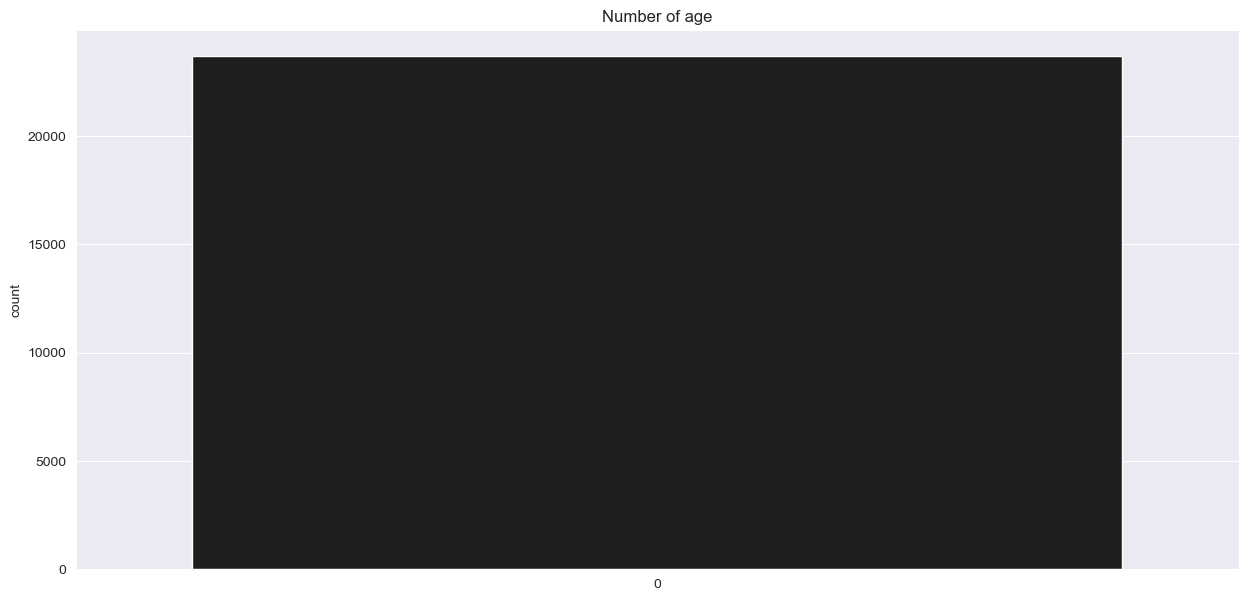

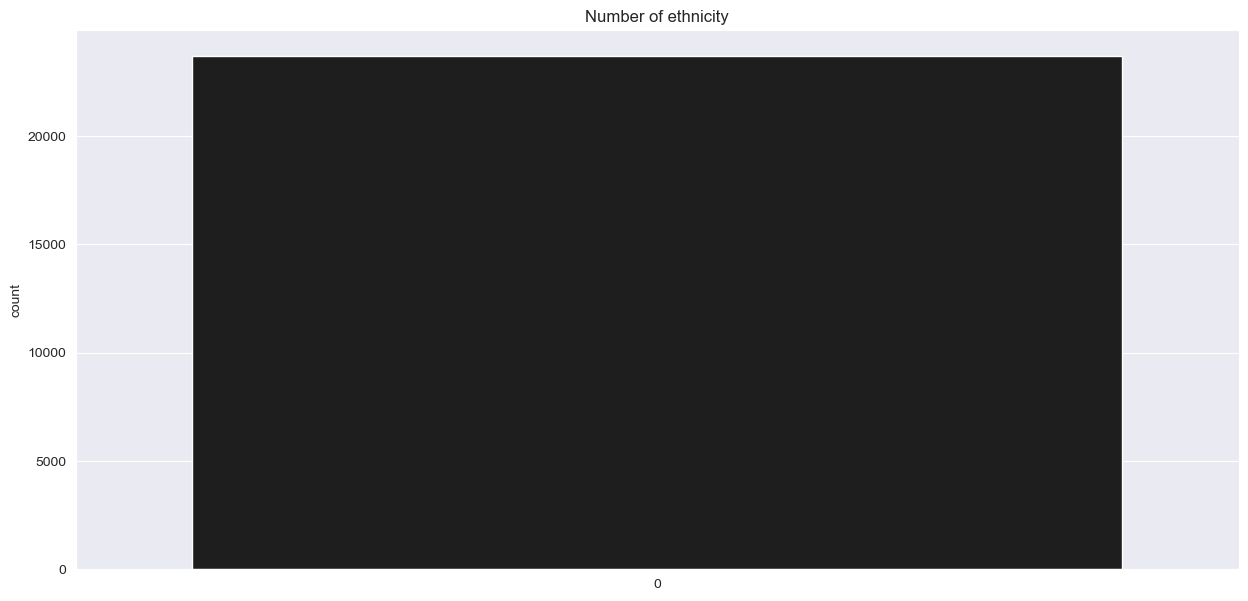

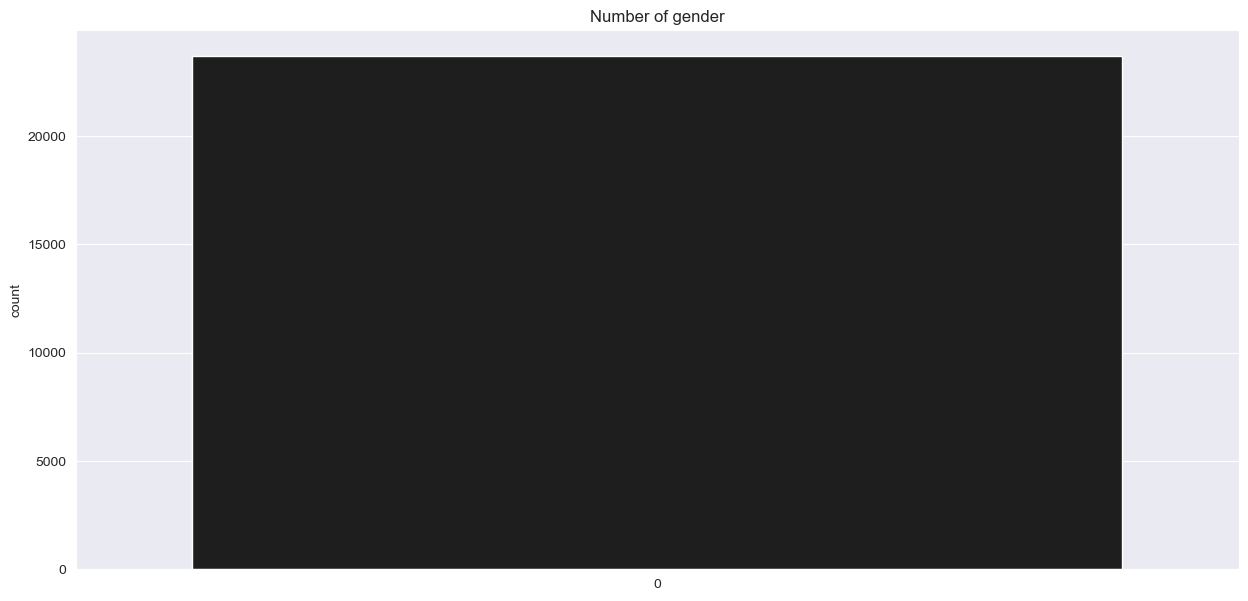

In [12]:
for i in y.columns:
    plt.figure(figsize=(15,7))
    g = sns.countplot(y[i], palette="icefire")
    plt.title("Number of {}".format(i))

Text(0.5, 1.0, 'Number of age')

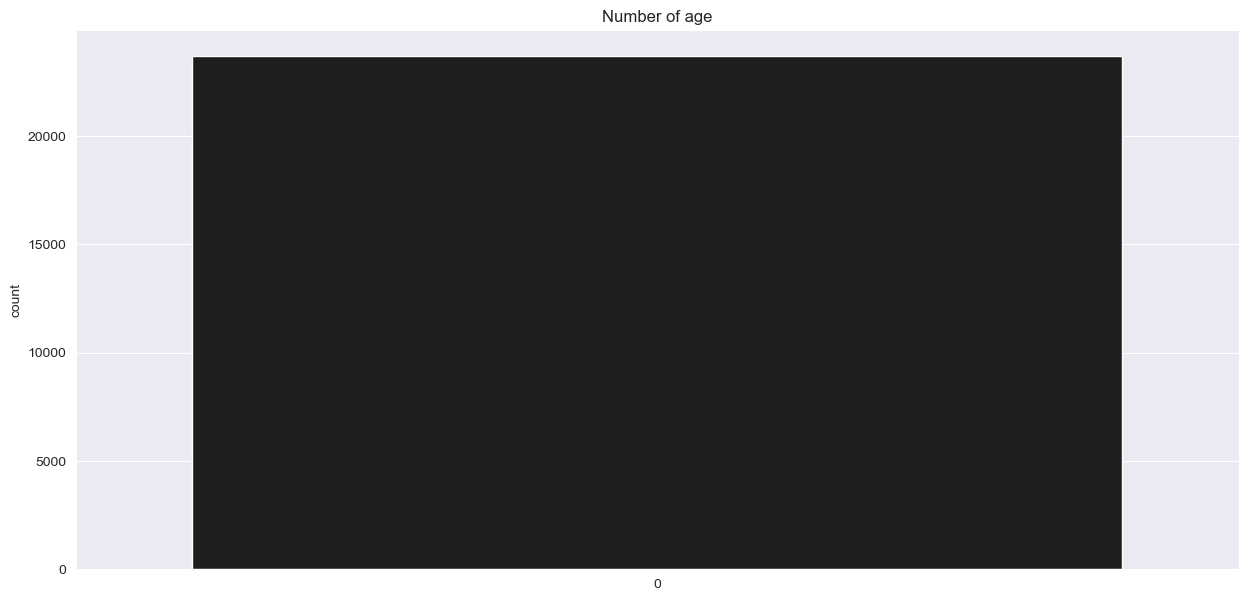

In [12]:
y["age"] = pd.cut(y["age"],bins=[0,3,18,45,64,116],labels=["0","1","2","3","4"])
plt.figure(figsize=(15,7))
g = sns.countplot(y["age"], palette="icefire")
plt.title("Number of age")

# Image shape

In [13]:
num_pixels = len(X['pixels'][0].split(" "))
img_height = int(np.sqrt(len(X['pixels'][0].split(" "))))
img_width = int(np.sqrt(len(X['pixels'][0].split(" "))))
print(num_pixels, img_height, img_width)

2304 48 48


# Reshape data

In [ ]:
X = pd.Series(X['pixels'])
X = X.apply(lambda x:x.split(' '))
X = X.apply(lambda x:np.array(list(map(lambda z:np.int(z), x))))
X = np.array(X)
X = np.stack(np.array(X), axis=0)

# reshape data
X = X.reshape(-1, 48, 48, 1)
print("X shape: ", X.shape)

# Image Overview

In [ ]:
plt.figure(figsize=(16,16))
for i,a in zip(np.random.randint(0, 23705, 25), range(1,26)):
    plt.subplot(5,5,a)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i])
    plt.xlabel(
    "Age: "+str(y['age'].iloc[i])+
    " Ethnicity:"+str(y['ethnicity'].iloc[i])+
    " Gender:"+str(y['gender'].iloc[i]))
plt.show()

# Building Neural Networks for AGE, GENDER AND ETHNICITY

In [22]:
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
import plotly.express as px
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy

In [18]:
!pip install tensorflow

     -------------------------------------- 272.8/272.8 MB 1.1 MB/s eta 0:00:00
     -------------------------------------- 65.5/65.5 kB 708.3 kB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 1.0 MB/s eta 0:00:00
     -------------------------------------- 126.5/126.5 kB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 4.1/4.1 MB 892.5 kB/s eta 0:00:00
     -------------------------------------- 422.5/422.5 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 1.2 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 5.6/5.6 MB 907.6 kB/s eta 0:00:00
     -----------------------------

# Categorizing target values

In [23]:
age_matrix = np.array(y['age'])
gender_matrix = np.array(y['gender'])
ethnicity_matrix = np.array(y['ethnicity'])
age = to_categorical(age_matrix, num_classes = 5)
gender = to_categorical(y["gender"], num_classes = 2)
ethnicity = to_categorical(ethnicity_matrix, num_classes = 5)
print(age, gender, ethnicity)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]] [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] [[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


# Normalize the data

In [24]:
X = X / 255
X = X / 255

# Image Data Generator

In [25]:
datagen = ImageDataGenerator(
        featurewise_center = False,
    # set input mean to 0 over the dataset
       samplewise_center = False,
    # set each sample mean to 0 
       featurewise_std_normalization = False,
    # divide inputs by std of the dataset
       samplewise_std_normalization=False,  
    # divide each input by its std
       zca_whitening=False,
    # dimesion reduction
       rotation_range=5, 
    # randomly rotate images in the range 5 degrees
       zoom_range = 0.1,
    # Randomly zoom image 10%
       width_shift_range=0.1, 
    # randomly shift images horizontally 10%
       height_shift_range=0.1,  
    # randomly shift images vertically 10%
       horizontal_flip=False,  
    # randomly flip images
        vertical_flip=False  # randomly flip images
)

datagen.fit(X)

# Train Test Split

In [26]:
# Ethnicity
from sklearn.model_selection import train_test_split
X_train_ethnicity, X_test_ethnicity, y_train_ethnicity, y_test_ethnicity = train_test_split(X,ethnicity, test_size=0.3, random_state=42)

# Gender
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X, gender, test_size=0.3, random_state=42)

# Age
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, age, test_size=0.3, random_state=42)

print(X_train_ethnicity.shape, X_train_gender.shape, X_train_age.shape)

(16593, 48, 48, 1) (16593, 48, 48, 1) (16593, 48, 48, 1)


# Building CNN Model

In [27]:
def my_model(num_classes, activation, loss):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = "same", input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3,3),activation="relu",padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3,3),activation="relu",padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dense(num_classes, activation=activation))
    
    model.compile(optimizer='Adam',
              loss= loss,
              metrics=['accuracy'])
    return model

# Callbacks

In [28]:
early_stopping = EarlyStopping(patience=10, 
                               min_delta=0.001,
                               restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                           patience = 2,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr = 0.00001)

# Ethnicity Prediction

In [29]:
epochs = 500  # for better result increase the epochs
batch_size = 64
model_ethnicity = my_model(5,"softmax",'categorical_crossentropy')
history_ethnicity = model_ethnicity.fit(X_train_ethnicity, y_train_ethnicity, batch_size=batch_size,
                              epochs = epochs, validation_data = (X_test_ethnicity,y_test_ethnicity), steps_per_epoch= X_train_ethnicity.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

Epoch 1/500
259/259 [==============================] - 61s 230ms/step - loss: 1.2022 - accuracy: 0.5630 - val_loss: 1.8621 - val_accuracy: 0.1436 - lr: 0.0010
Epoch 2/500
259/259 [==============================] - 72s 277ms/step - loss: 0.8737 - accuracy: 0.6826 - val_loss: 2.2767 - val_accuracy: 0.4920 - lr: 0.0010
Epoch 3/500
259/259 [==============================] - 70s 270ms/step - loss: 0.7834 - accuracy: 0.7189 - val_loss: 2.3370 - val_accuracy: 0.1645 - lr: 0.0010
Epoch 4/500
259/259 [==============================] - 72s 278ms/step - loss: 0.7233 - accuracy: 0.7407 - val_loss: 2.8807 - val_accuracy: 0.4326 - lr: 0.0010
Epoch 5/500
259/259 [==============================] - 67s 257ms/step - loss: 0.6796 - accuracy: 0.7589 - val_loss: 1.4841 - val_accuracy: 0.3992 - lr: 0.0010
Epoch 6/500
259/259 [==============================] - 62s 239ms/step - loss: 0.6343 - accuracy: 0.7728 - val_loss: 2.8930 - val_accuracy: 0.4318 - lr: 0.0010
Epoch 7/500
259/259 [=========================

In [30]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Plotting model performance

In [33]:
fig = px.line(
    history_ethnicity.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

# Loss & Accuracy

In [34]:
loss, acc = model_ethnicity.evaluate(X_test_ethnicity, y_test_ethnicity, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 1.4841272830963135
Test Accuracy: 0.3991844654083252


# Age Prediction

In [35]:
model_age = my_model(5,"softmax",'categorical_crossentropy')
history_age = model_age.fit(X_train_age, y_train_age, batch_size=batch_size,
                              epochs = epochs, validation_data = (X_test_age,y_test_age), 
                            steps_per_epoch= X_train_age.shape[0] // batch_size, 
                            callbacks= [early_stopping, 
                            learning_rate_reduction])

Epoch 1/500
259/259 [==============================] - 60s 225ms/step - loss: 0.9692 - accuracy: 0.6473 - val_loss: 3.2532 - val_accuracy: 0.1551 - lr: 0.0010
Epoch 2/500
259/259 [==============================] - 62s 240ms/step - loss: 0.7118 - accuracy: 0.7238 - val_loss: 1.4926 - val_accuracy: 0.5734 - lr: 0.0010
Epoch 3/500
259/259 [==============================] - 64s 247ms/step - loss: 0.6482 - accuracy: 0.7443 - val_loss: 7.8549 - val_accuracy: 0.0828 - lr: 0.0010
Epoch 4/500
259/259 [==============================] - 65s 251ms/step - loss: 0.6032 - accuracy: 0.7627 - val_loss: 3.7219 - val_accuracy: 0.5792 - lr: 0.0010
Epoch 5/500
259/259 [==============================] - 61s 234ms/step - loss: 0.5661 - accuracy: 0.7738 - val_loss: 6.0632 - val_accuracy: 0.5782 - lr: 0.0010
Epoch 6/500
259/259 [==============================] - 60s 233ms/step - loss: 0.5426 - accuracy: 0.7867 - val_loss: 52.4157 - val_accuracy: 0.5782 - lr: 0.0010
Epoch 7/500
259/259 [========================

# Plotting model performance


In [36]:

fig = px.line(
    history_age.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

# Loss & Accuracy

In [37]:
loss, acc = model_age.evaluate(X_test_age, y_test_age, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 1.4925742149353027
Test Accuracy: 0.5733970999717712


# Gender Prediction

In [38]:
model_gender = my_model(2, "sigmoid", "binary_crossentropy")
history_gender = model_gender.fit(X_train_gender, y_train_gender, 
                                 batch_size = batch_size,
                                 epochs = epochs,
                                 validation_data = (X_test_gender, y_test_gender),
                                 steps_per_epoch = X_train_gender.shape[0] // batch_size, callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/500
259/259 [==============================] - 62s 230ms/step - loss: 0.4961 - accuracy: 0.7712 - val_loss: 1.2285 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 2/500
259/259 [==============================] - 59s 227ms/step - loss: 0.3540 - accuracy: 0.8356 - val_loss: 2.9306 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 3/500
259/259 [==============================] - 58s 223ms/step - loss: 0.3177 - accuracy: 0.8565 - val_loss: 0.3498 - val_accuracy: 0.8417 - lr: 0.0010
Epoch 4/500
259/259 [==============================] - 58s 223ms/step - loss: 0.2949 - accuracy: 0.8674 - val_loss: 0.3613 - val_accuracy: 0.8349 - lr: 0.0010
Epoch 5/500
259/259 [==============================] - 58s 222ms/step - loss: 0.2696 - accuracy: 0.8837 - val_loss: 0.2924 - val_accuracy: 0.8747 - lr: 0.0010
Epoch 6/500
259/259 [==============================] - 57s 222ms/step - loss: 0.2577 - accuracy: 0.8906 - val_loss: 0.4235 - val_accuracy: 0.8313 - lr: 0.0010
Epoch 7/500
259/259 [=========================

In [39]:
fx = px.line(
    history_gender.history, y=["loss", "val_loss"],
    labels = {'index':'epoch', 'value':'loss'},
    title = 'Training History')
fig.show()

# Loss and Accuracy

In [40]:
loss, acc = model_gender.evaluate(X_test_gender, y_test_gender, verbose=0)
print("Test loss: {}".format(loss))
print("Test Accuracy: {}".format(acc))

Test loss: 0.2924399673938751
Test Accuracy: 0.8747187852859497


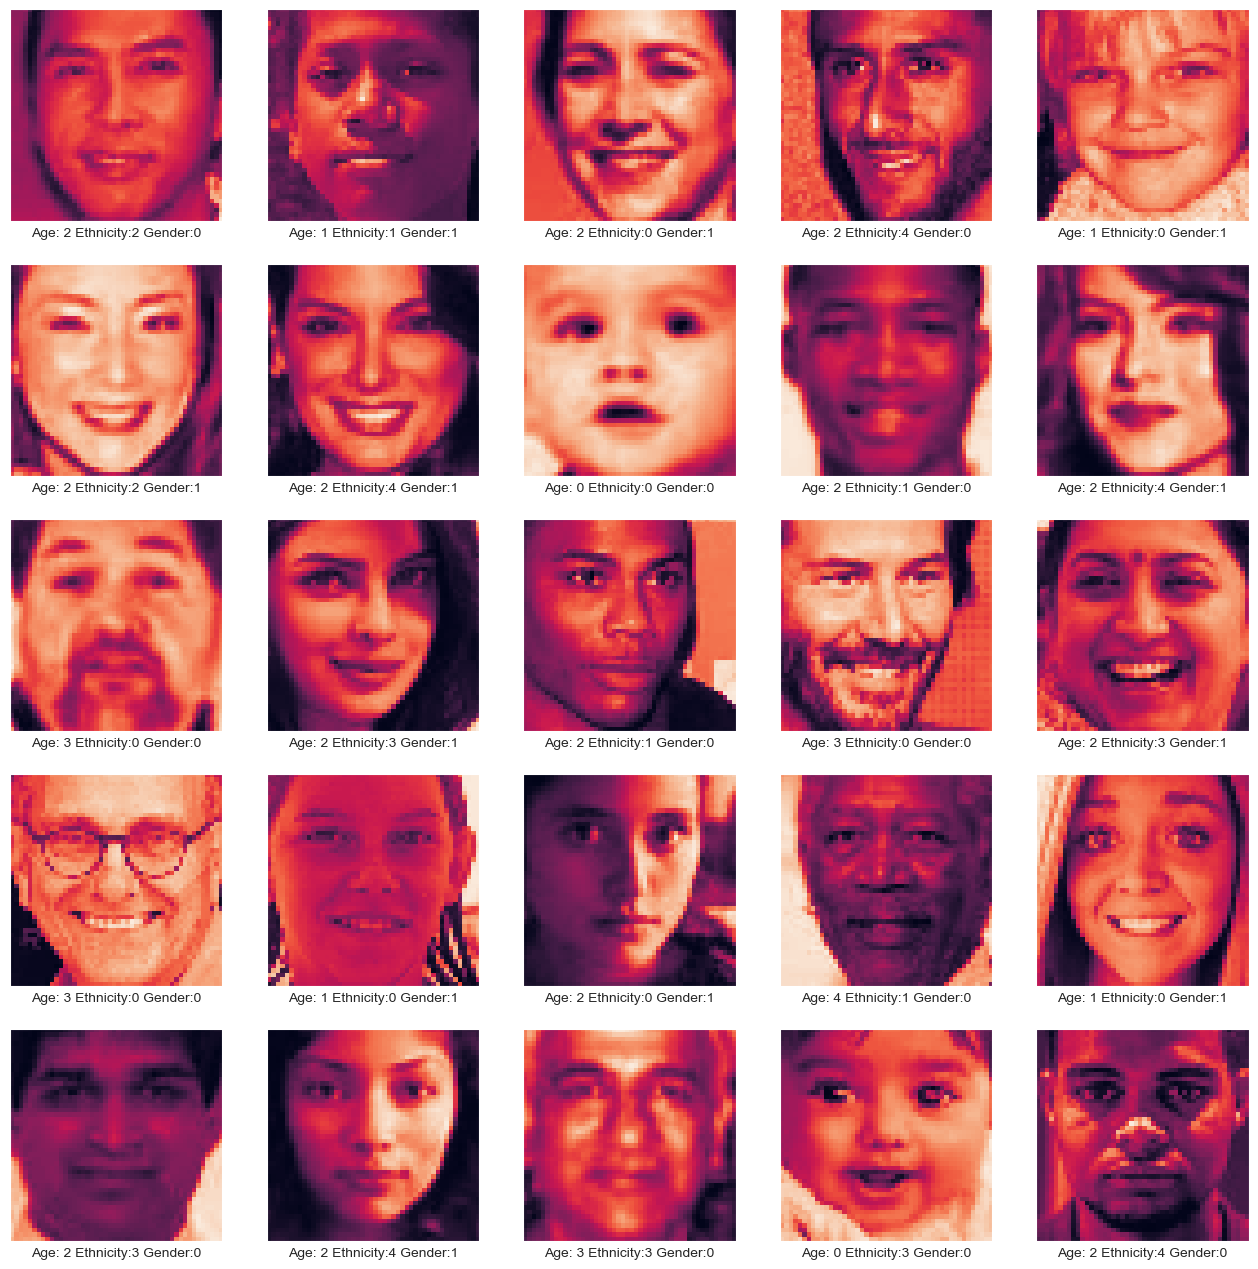

In [42]:
plt.figure(figsize=(16,16))
for i,a in zip(np.random.randint(0, 23705, 25), range(1,26)):
    plt.subplot(5,5,a)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i])
    plt.xlabel(
    "Age: "+str(y['age'].iloc[i])+
    " Ethnicity:"+str(y['ethnicity'].iloc[i])+
    " Gender:"+str(y['gender'].iloc[i]))
plt.show()